In [21]:
import pandas as pd
import numpy as np
from pandas import json_normalize 
import datetime as dt
from datetime import datetime
import time
import requests
import json



import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_colwidth', None)



In [22]:
# get protocols
lst_protocols = ['marinade-finance','lido', 'jito', 'blazestake','jpool','socean', 'marginfi-lst']
dex_protocols = ['orca', 'raydium','lifinity','open','saber']
derivatives_protocols = ['drift', 'mango-markets', 'cypher']
length = len(lst_protocols)

In [23]:
for i in range(length):
    response = requests.get("https://api.llama.fi/protocol/"+lst_protocols[i])
    data = response.json()
    if lst_protocols[i] == 'marinade-finance': 
        marinade = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        marinade = marinade.rename({'tokens.SOL': 'marinade_sol'}, axis=1)
        marinade['date'] = pd.to_datetime(marinade['date'], unit='s').dt.strftime('%Y-%m-%d')
    if lst_protocols[i] == 'lido': 
        lido = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        lido = lido.rename({'tokens.SOL': 'lido_sol'}, axis=1)
        lido['date'] = pd.to_datetime(lido['date'], unit='s').dt.strftime('%Y-%m-%d')
    if lst_protocols[i] == 'jito': 
        jito = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        jito = jito.rename({'tokens.SOL': 'jito_sol'}, axis=1)
        jito['date'] = pd.to_datetime(jito['date'], unit='s').dt.strftime('%Y-%m-%d')  
    if lst_protocols[i] == 'blazestake': 
        blaze = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        blaze = blaze.rename({'tokens.BSOL': 'blaze_sol'}, axis=1)
        blaze['date'] = pd.to_datetime(blaze['date'], unit='s').dt.strftime('%Y-%m-%d')
    if lst_protocols[i] == 'jpool': 
        jpool = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        jpool = jpool.rename({'tokens.JSOL': 'jpool_sol'}, axis=1)
        jpool['date'] = pd.to_datetime(jpool['date'], unit='s').dt.strftime('%Y-%m-%d')
    if lst_protocols[i] == 'socean': 
        socean = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        socean = socean.rename({'tokens.SOL': 'socean_sol'}, axis=1)
        socean['date'] = pd.to_datetime(socean['date'], unit='s').dt.strftime('%Y-%m-%d')
    if lst_protocols[i] == 'marginfi-lst': 
        marginfi = pd.json_normalize(data['chainTvls']['Solana']['tokens'])
        marginfi = marginfi.rename({'tokens.SOL': 'marginfi_sol'}, axis=1)
        marginfi['date'] = pd.to_datetime(marginfi['date'], unit='s').dt.strftime('%Y-%m-%d')
    
#join
df = marinade.merge(lido, left_on='date', right_on='date', how='left')
df = df.merge(jito, left_on='date', right_on='date', how='left')
df = df.merge(blaze, left_on='date', right_on='date', how='left')
df = df.merge(jpool, left_on='date', right_on='date', how='left')
df = df.merge(socean, left_on='date', right_on='date', how='left')
df = df.merge(marginfi, left_on='date', right_on='date', how='left')


#sum
cols = list(df)
cols.remove("date")
df["sum"] = df[cols].sum(axis=1)

In [24]:
#distribution
df['marinade_distribution'] = df['marinade_sol'] / df['sum']
df['lido_distribution'] = df['lido_sol'] / df['sum']
df['jito_distribution'] = df['jito_sol'] / df['sum']
df['blaze_distribution'] = df['blaze_sol'] / df['sum']
df['jpool_distribution'] = df['jpool_sol'] / df['sum']
df['socean_distribution'] = df['socean_sol'] / df['sum']
df['socean_distribution'] = df['socean_sol'] / df['sum']
df['marginfi_distribution'] = df['marginfi_sol'] / df['sum']


In [25]:
# Get token
token = pd.read_csv("env.csv")
value = token[token["Key"] == "VALIDATORS_TOKEN"]["Value"].values[0]

# Define the URL and headers
url = 'https://www.validators.app/api/v1/validators/mainnet.json?per=5000'
headers = {'Token': value}

# Send the GET request
response = requests.get(url, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # You can access the response content as a string
    data = json.loads(response.text)
    total_stake = pd.DataFrame(data)
    total_stake.head()
else:
    print(f"Request failed with status code {response.status_code}")

# Convert lamports to SOL
total_active_stake = total_stake['active_stake'].sum() / 1000000000


# Get total SOL staked by liquid staking protocols
lst_stake = df['sum'].tail(1).values[0]

# Calculate LST share
percentage = (lst_stake / total_active_stake) * 100

print(f"SOL staked by liquid staking protocols: {lst_stake}")
print(f"Total SOL staked: {total_active_stake}")
print(f"Share of LST: {percentage:.2f}%")

SOL staked by liquid staking protocols: 11513869.32581
Total SOL staked: 418256549.6916344
Share of LST: 2.75%


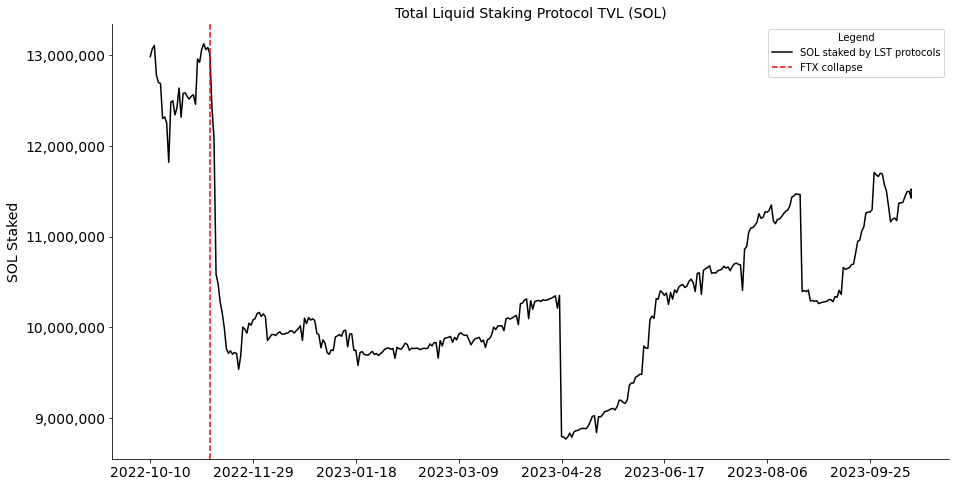

In [26]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
total = df['sum']

plt.plot(x,total, label='SOL staked by LST protocols', color ='Black')

# Add a vertical line on November 8, 2022
ftx_collapse_date = '2022-11-08'
plt.axvline(ftx_collapse_date, color='red', linestyle='--', label='FTX collapse')

#add legend
plt.legend(title='Legend')

#remove lines
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)     

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.title('Total Liquid Staking Protocol TVL (SOL)', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('SOL Staked',fontsize=14) # y label
plt.show()

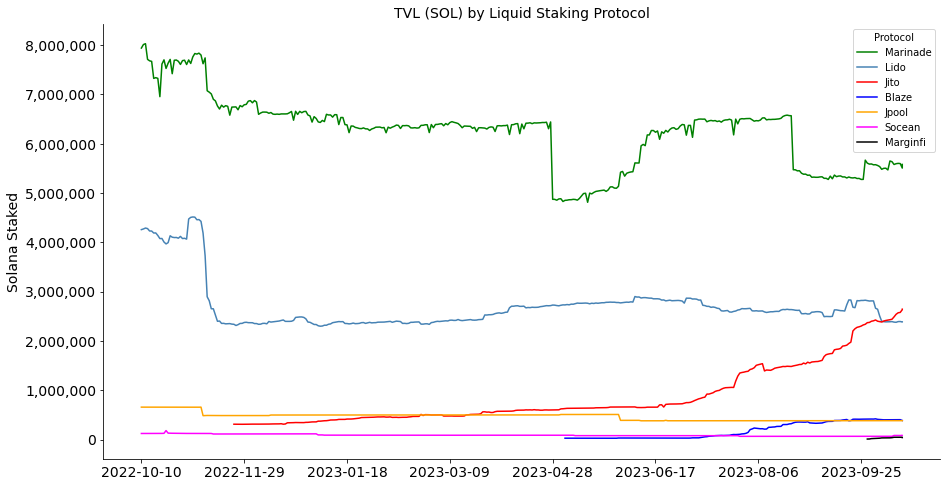

In [27]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
marinade = df['marinade_sol']
lido = df['lido_sol']
jito = df['jito_sol']
blaze = df['blaze_sol']
jpool = df['jpool_sol']
socean = df['socean_sol']
marginfi = df['marginfi_sol']

plt.plot(x,marinade, label='Marinade', color ='green')
plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jito, label='Jito', color ='red')
plt.plot(x,blaze, label='Blaze', color ='blue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')
plt.plot(x,marginfi, label='Marginfi', color ='black')

#add legend
plt.legend(title='Protocol')


#remove lines
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)     

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('TVL (SOL) by Liquid Staking Protocol', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

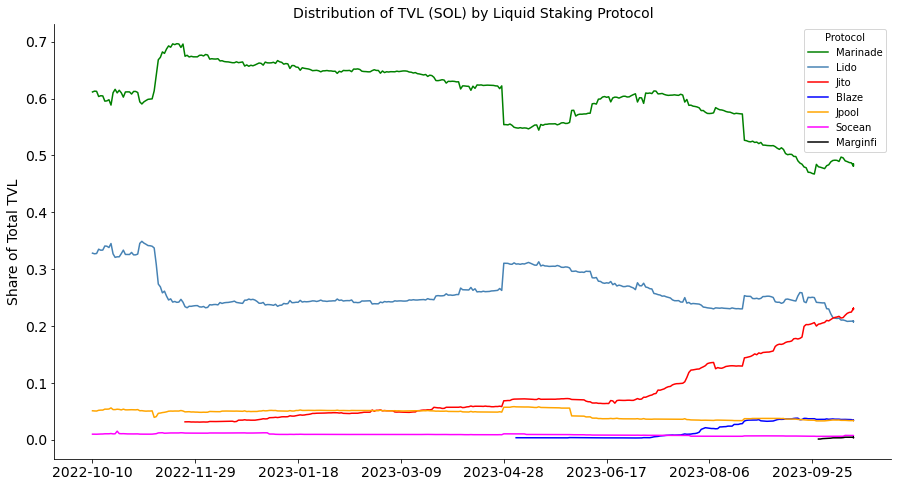

In [28]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
marinade = df['marinade_distribution']
lido = df['lido_distribution']
jito = df['jito_distribution']
blaze = df['blaze_distribution']
jpool = df['jpool_distribution']
socean = df['socean_distribution']
marginfi = df['marginfi_distribution']

plt.plot(x,marinade, label='Marinade', color ='green')
plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jito, label='Jito', color ='red')
plt.plot(x,blaze, label='Blaze', color ='blue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')
plt.plot(x,marginfi, label='Marginfi', color ='black')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)      
ax.spines["right"].set_visible(False)      

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('Distribution of TVL (SOL) by Liquid Staking Protocol', fontsize=14) # adding a title
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Share of Total TVL',fontsize=14) # y label
plt.show()

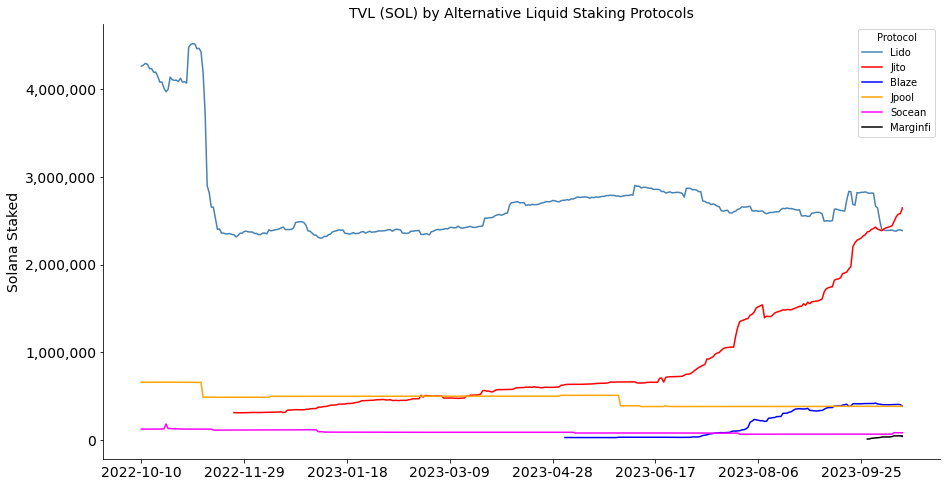

In [29]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = df['date']
lido = df['lido_sol']
jito = df['jito_sol']
blaze = df['blaze_sol']
jpool = df['jpool_sol']
socean = df['socean_sol']
marginfi = df['marginfi_sol']

plt.plot(x,lido, label='Lido', color ='steelblue')
plt.plot(x,jito, label='Jito', color ='red')
plt.plot(x,blaze, label='Blaze', color ='blue')
plt.plot(x,jpool, label='Jpool', color ='orange')
plt.plot(x,socean, label='Socean', color ='magenta')
plt.plot(x,marginfi, label='Marginfi', color ='black')

#add legend
plt.legend(title='Protocol')

#remove lines
ax.spines["top"].set_visible(False)     
ax.spines["right"].set_visible(False)     

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('TVL (SOL) by Alternative Liquid Staking Protocols', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('Solana Staked',fontsize=14) # y label
plt.show()

In [30]:
# Marinade Finance has a direct stake product and liquids taking product
# Can return total staked via their Grafana Dashboard: https://stats.marinade.finance/d/sqUQd1Onk/marinade-kpi-dashboard?orgId=1&refresh=1d&from=now-1y&to=now&viewPanel=67
# Extract is from October 9th, 2023
marinade_native = pd.read_csv("marinade-native-tvl.csv")

# Remove duplicate dates
marinade_native = marinade_native[marinade_native['Time'].str.endswith('00:00:00')]

# Turn into dt
marinade_native['Time'] = pd.to_datetime(marinade_native['Time'])

# Rename columns
marinade_native = marinade_native.rename(columns={'Time': 'date'})
marinade_native = marinade_native.rename(columns={'SOL Staked': 'marinade_native_staked'})

# Set to correct data type
marinade_native['date'] = marinade_native['date'].astype(str)

In [31]:
# wrangle data
marinadeData = df.merge(marinade_native, on='date', how='left')
marinadeData = marinadeData[['date', 'marinade_native_staked', 'marinade_sol']]
marinadeData.fillna(0, inplace=True)
marinadeData['marinade_total'] = marinadeData['marinade_native_staked'] + marinadeData['marinade_sol']

marinadeData.head()

,date,marinade_native_staked,marinade_sol,marinade_total
0,2022-10-10,0.0,7.939290e+06,7.939290e+06
1,2022-10-11,0.0,8.010823e+06,8.010823e+06
2,2022-10-12,0.0,8.028273e+06,8.028273e+06
3,2022-10-13,0.0,7.710515e+06,7.710515e+06
4,2022-10-14,0.0,7.680980e+06,7.680980e+06


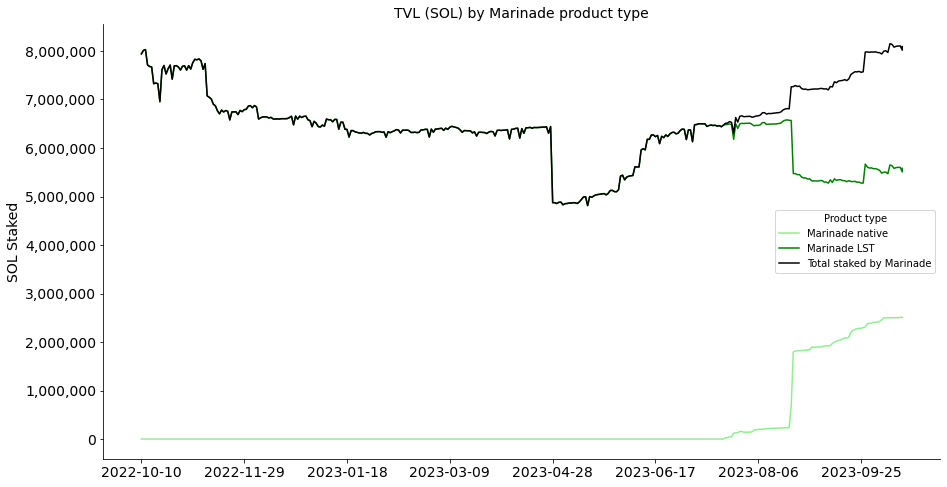

In [32]:
fig, ax = plt.subplots(figsize=(15, 8)) # resizing the plot

x = marinadeData['date']
marinade_native = marinadeData['marinade_native_staked']
marinade_lst = marinadeData['marinade_sol']
marinade_total = marinadeData['marinade_total']


plt.plot(x,marinade_native, label='Marinade native', color ='lightgreen')
plt.plot(x,marinade_lst, label='Marinade LST', color ='green')
plt.plot(x,marinade_total, label='Total staked by Marinade', color ='black')


#add legend
plt.legend(title='Product type')

#remove lines
ax.spines["top"].set_visible(False)     
ax.spines["right"].set_visible(False)     

# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Make sure your axis ticks are large enough to be easily read.      
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)    
ax.xaxis.set_major_locator(plt.MaxNLocator(10))


plt.title('TVL (SOL) by Marinade product type', fontsize=14) # adding a title
ax.yaxis.set_major_formatter('{x:1,.0f}')
plt.xlabel('',fontsize=14) # x label
plt.ylabel('SOL Staked',fontsize=14) # y label
plt.show()

In [ ]:
df.to_csv('liquid_staking.csv')